In [147]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import seaborn.objects as so

from opf.test import load_run, test_run

mpl.rcParams["text.usetex"] = False

sns.set_style("white")
sns.set_context("paper")

torch.set_float32_matmul_precision("high")

In [149]:
import wandb

api = wandb.Api()
runs = api.runs(
    "damowerko-academic/opf",
    filters={
        "$and": [{"config.max_epochs": 5000}, {"created_at": {"$gt": "2025-03-11"}}]
    },
)

In [150]:
run_dict = {}
for run in runs:
    case_name = run.config["case_name"]
    # Rename case names to pretty ones
    if "case30_ieee" in case_name:
        case_name = "IEEE 30"
    elif "case57_ieee" in case_name:
        case_name = "IEEE 57"
    elif "case118_ieee" in case_name:
        case_name = "IEEE 118"
    elif "case179_goc" in case_name:
        case_name = "GOC 179"
    elif "case200_activ" in case_name:
        case_name = "ACTIV 200"
    elif "case300_ieee" in case_name:
        case_name = "IEEE 300"
    elif "case1354_pegase" in case_name:
        case_name = "PEGASE 1354"

    tags = set(run.tags)
    if {"supervised"} == tags:
        model_name = "Supervised"
    elif {"supervised", "augmented"} == tags:
        model_name = "Supervised + Augmented"
    elif {"pointwise"} == tags:
        model_name = "Pointwise"
    elif {"pointwise", "supervised-warmup"} == tags:
        model_name = "Pointwise + Supervised Warmup"
    elif {"shared"} == tags:
        model_name = "Shared"
    elif {"shared", "supervised-warmup"} == tags:
        model_name = "Shared + Supervised Warmup"
    elif {"hybrid"} == tags:
        model_name = "Hybrid"
    elif {"hybrid", "supervised-warmup"} == tags:
        model_name = "Hybrid + Supervised Warmup"

    tags = run.tags
    run_id = run.id
    if case_name not in run_dict:
        run_dict[case_name] = {}
    run_dict[case_name][model_name] = run_id

case_names = [
    "IEEE 30",
    "IEEE 57",
    "IEEE 118",
    "GOC 179",
    "ACTIV 200",
    "IEEE 300",
    # "PEGASE 1354",
]
model_names = [
    "Supervised",
    "Supervised + Augmented",
    "Pointwise",
    "Pointwise + Supervised Warmup",
    "Shared",
    "Shared + Supervised Warmup",
    "Hybrid",
    "Hybrid + Supervised Warmup",
]
model_type_dict = {
    "Supervised": "Supervised",
    "Supervised + Augmented": "Supervised",
    "Pointwise": "Dual-Pointwise",
    "Pointwise + Supervised Warmup": "Dual-Pointwise",
    "Shared": "Dual-Shared",
    "Shared + Supervised Warmup": "Dual-Shared",
    "Hybrid": "Dual-Pointwise",
    "Hybrid + Supervised Warmup": "Dual-Pointwise",
}

In [151]:
dfs = []
for case_name in run_dict:
    # if case_name != "GOC 179":
    #     continue
    for model_name, id in run_dict[case_name].items():
        if id == "":
            continue
        # Load test results from consistent /tmp path
        df = test_run(id, load_existing=True, project=True, clamp=False)
        df = df.assign(id=id, case_name=case_name, model_name=model_name)
        dfs.append(df)

df = pd.concat(dfs)


In [152]:
index = pd.MultiIndex.from_product([case_names, model_names], names=["Case", "Model"])
df["optimality_gap"] = df["test/cost"] / df["acopf/cost"] - 1
df_summary = (
    df.groupby(["case_name", "model_name"])[
        [
            "optimality_gap",
            "test_normal/inequality/error_mean",
            "test_normal/inequality/error_max",
            "test_normal/equality/error_mean",
            "test_normal/equality/error_max",
        ]
    ]
    .mean()
    .reindex(index)
)
df_summary.style.format("{:.2%}", na_rep="--").set_table_styles(
    [
        {
            "selector": f"tr:nth-child({i * 8})",
            "props": [("border-bottom", "2px solid black")],
        }
        for i in range(1, 7)
    ]
)

In [153]:
# average performance across all cases
df_summary_average = df_summary.groupby("Model").mean()
df_summary_average.style.format("{:.2%}", na_rep="--")

,optimality_gap,test_normal/inequality/error_mean,test_normal/inequality/error_max,test_normal/equality/error_mean,test_normal/equality/error_max
Model,,,,,
Hybrid,2.15%,12.81%,36.59%,0.00%,0.00%
Hybrid + Supervised Warmup,1.56%,11.43%,35.01%,0.00%,0.00%
Pointwise,1.47%,19.30%,34.75%,0.00%,0.00%
Pointwise + Supervised Warmup,1.77%,18.56%,31.84%,0.00%,0.00%
Shared,4.51%,6.34%,33.51%,0.00%,0.00%
Shared + Supervised Warmup,2.43%,12.09%,96.65%,0.10%,0.10%
Supervised,0.18%,21.16%,45.03%,0.00%,0.00%
Supervised + Augmented,2.26%,35.69%,321.24%,3.15%,20.40%


In [154]:
df_summary.columns

Index(['optimality_gap', 'test_normal/inequality/error_mean',
       'test_normal/inequality/error_max', 'test_normal/equality/error_mean',
       'test_normal/equality/error_max'],
      dtype='object')

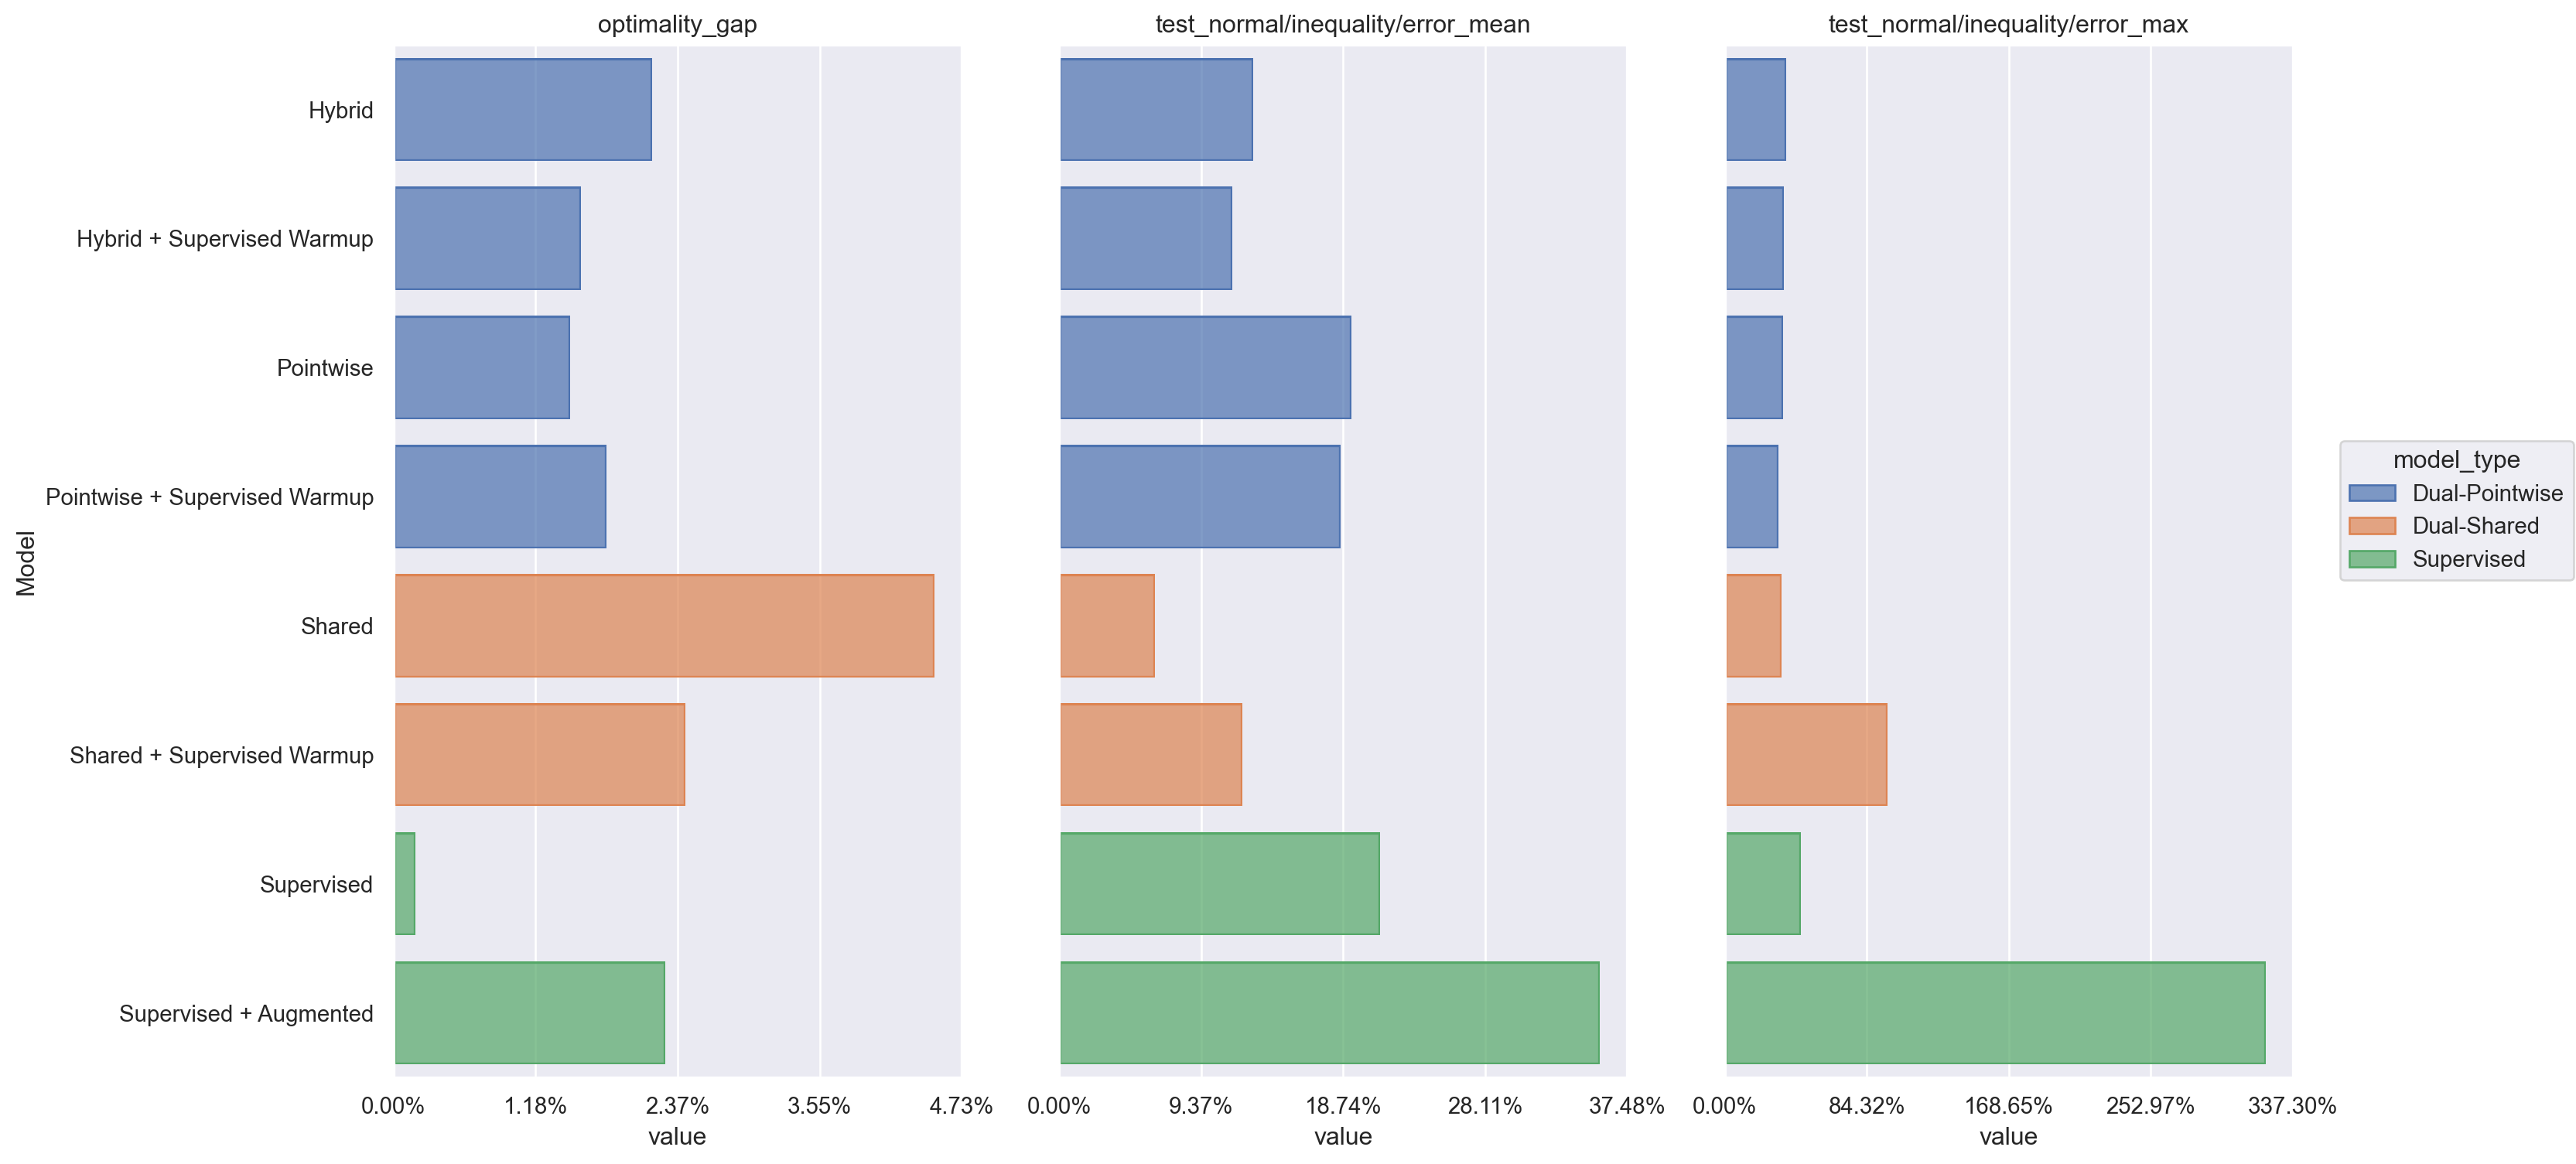

In [155]:
(
    so.Plot(
        df_summary_average[
            [
                "optimality_gap",
                "test_normal/inequality/error_mean",
                "test_normal/inequality/error_max",
            ]
        ]
        .melt(ignore_index=False)
        .reset_index()
        .assign(model_type=lambda df: df["Model"].map(model_type_dict)),
        x="value",
        y="Model",
        color="model_type",
    )
    .add(so.Bar())
    .facet(col="variable")
    .scale(x=so.Continuous().label(like="{x:.2%}").tick(count=5))
    .share(x=False)
    # .limit(x=(0, 0.2))
    .layout(size=(16, 8))
)

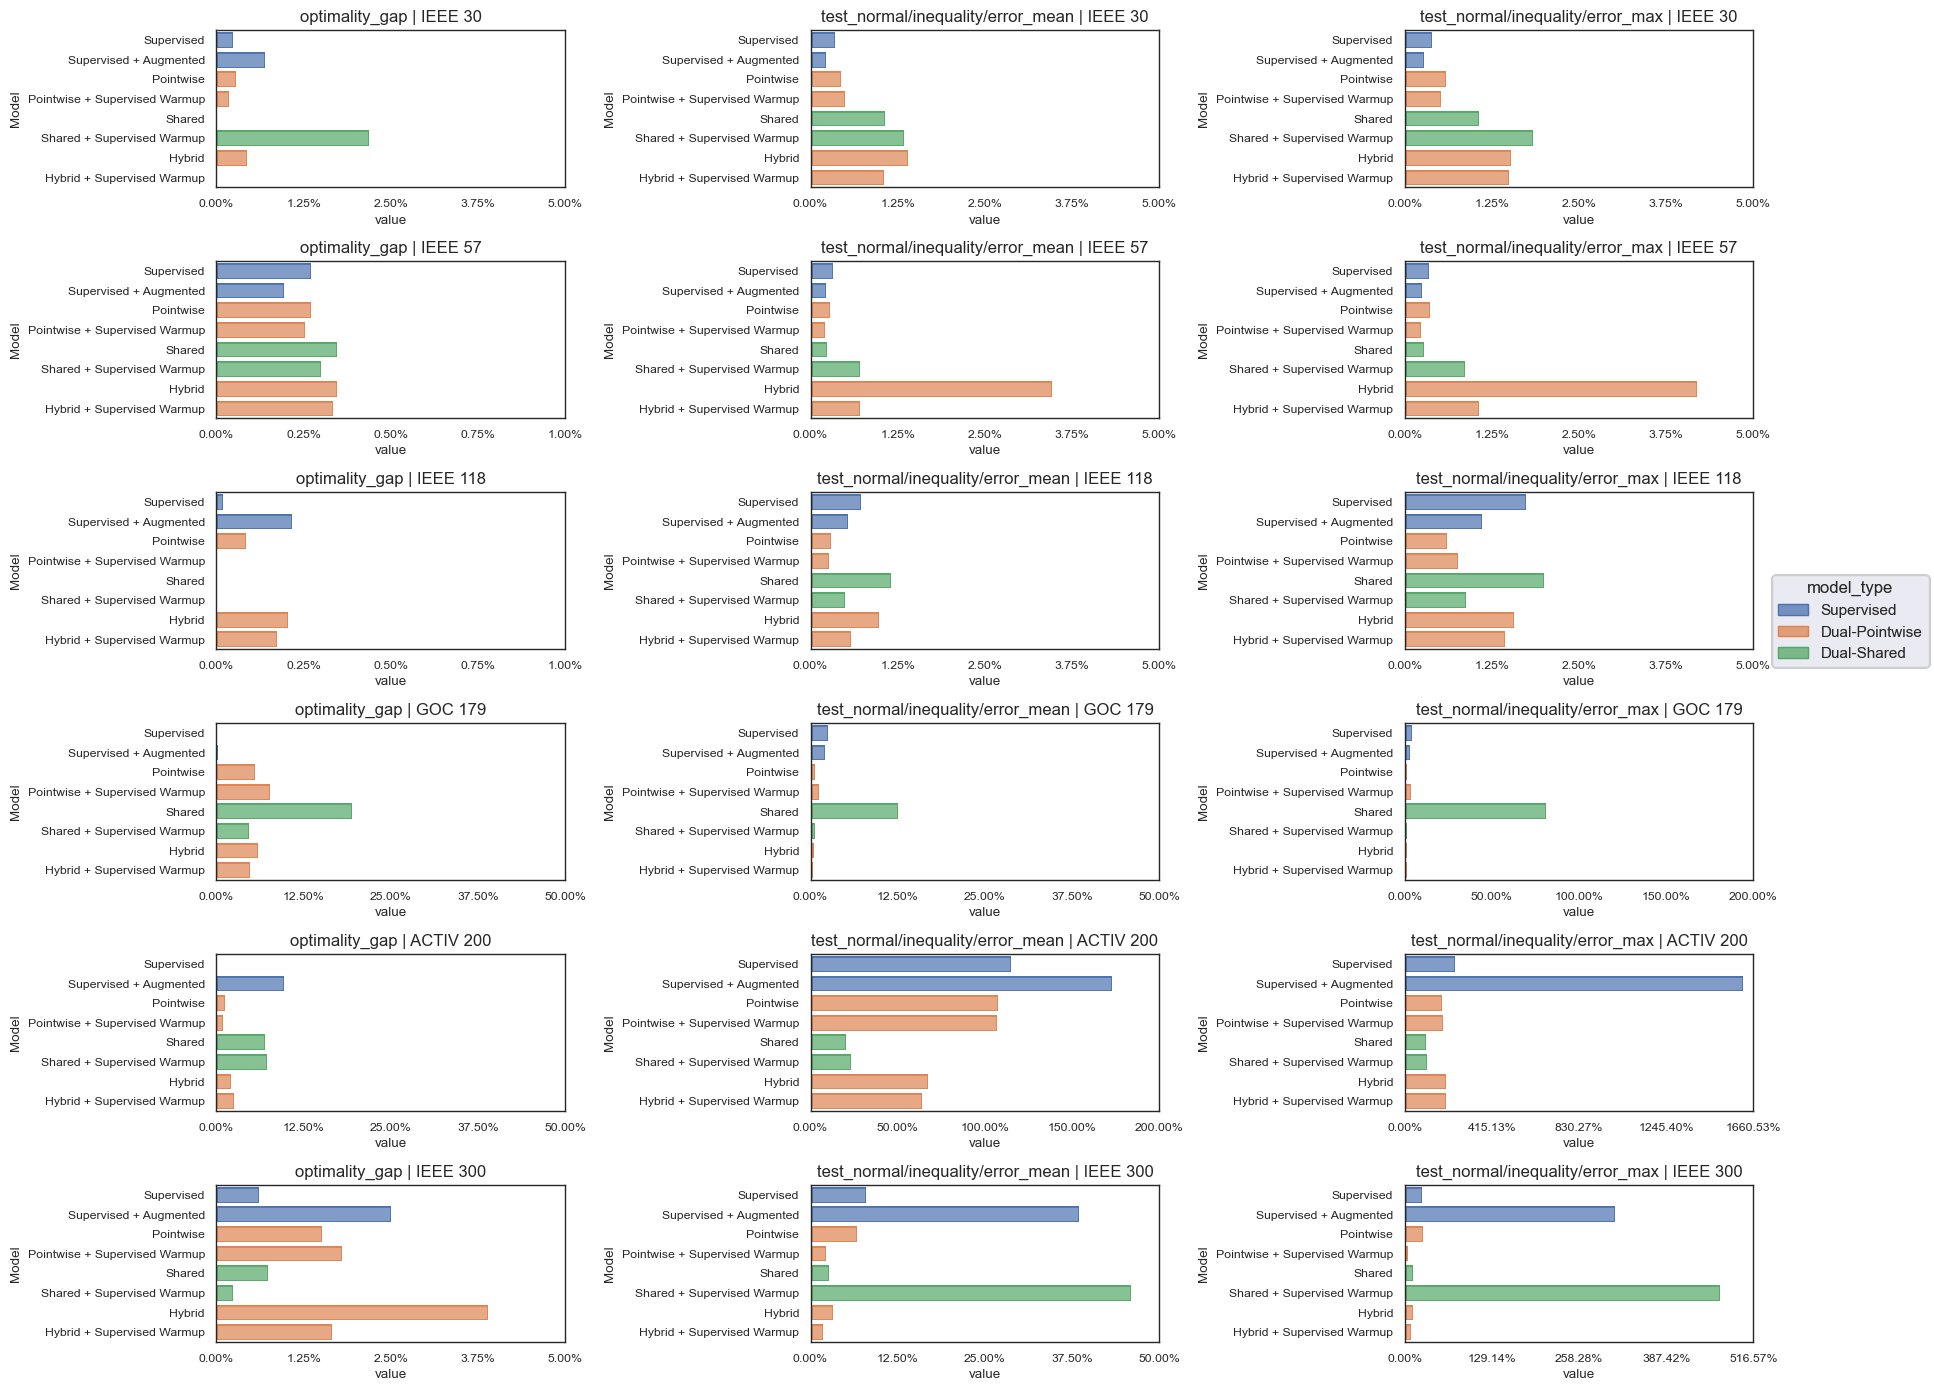

In [156]:
import seaborn.objects as so
# import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt

df_melted = (
    df_summary[
        ["optimality_gap", "test_normal/inequality/error_mean", "test_normal/inequality/error_max"]
    ]
    .melt(ignore_index=False)
    .reset_index()
    .assign(model_type=lambda df: df["Model"].map(model_type_dict))
)

def get_axis_limit(max_val):
    percent = max_val * 100
    if percent < 1:
        return 0.01
    elif percent < 5:
        return 0.05
    elif percent < 50:
        return 0.5
    elif percent < 200:
        return 2.0
    else:
        # return np.ceil(percent / 50) * 0.5 / 100
        return max_val+.5

facet_max = (
    df_melted.groupby(["Case", "variable"])["value"]
    .max()
    .reset_index(name="max_val")
    .assign(xlim=lambda df: df["max_val"].apply(get_axis_limit))
)

cases = df_melted["Case"].unique()
variables = df_melted["variable"].unique()

fig, axes = plt.subplots(len(cases), len(variables), figsize=(18, 14), sharey=True)

if len(cases) == 1:
    axes = np.expand_dims(axes, 0)
if len(variables) == 1:
    axes = np.expand_dims(axes, 1)

for i, case in enumerate(cases):
    for j, variable in enumerate(variables):
        ax = axes[i, j]
        subset = df_melted.query("Case == @case and variable == @variable")
        xlim = facet_max.query("Case == @case and variable == @variable")["xlim"].values[0]
        # if variable != "optimality_gap":
        #     ax.set_ylabel("")
        #     ax.set_yticklabels([])

        (
            so.Plot(subset, x="value", y="Model", color="model_type")
            .add(so.Bar())
            .scale(x=so.Continuous().label(like="{x:0.2%}").tick(count=5))
            .limit(x=(0, xlim))
            .on(ax)
            .label(title=f"{variable} | {case}")
            .plot()
        )

plt.tight_layout()
plt.show()

#try scatter plots
# make logarithmic share(x=True)

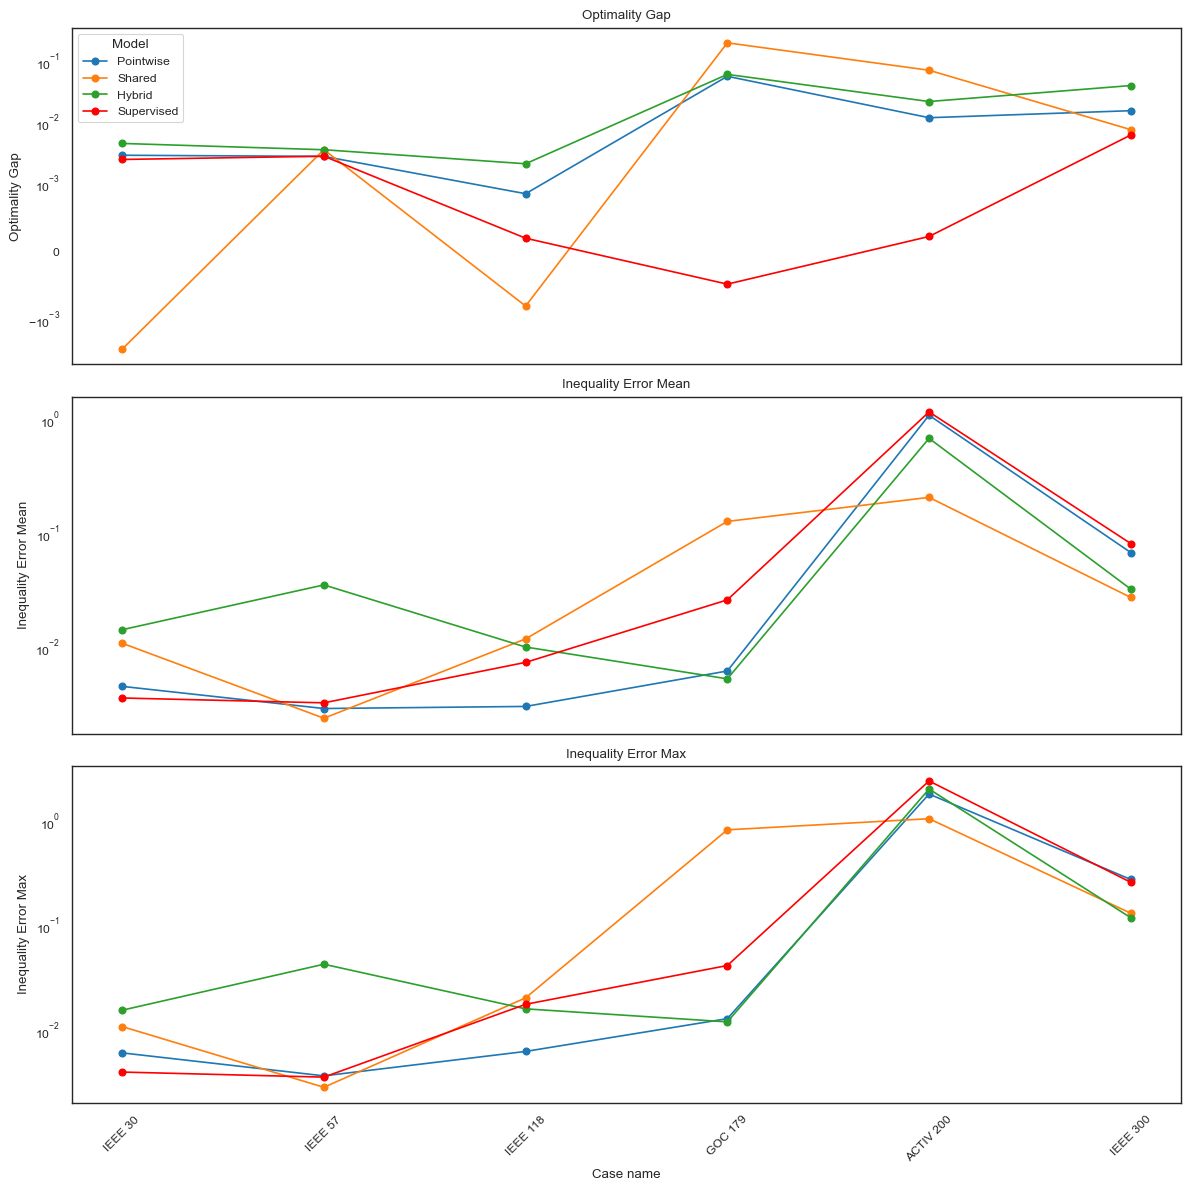

In [179]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

selected_models = [
    "Pointwise",
    "Shared",
    "Hybrid",
    "Supervised",
]



metrics = {
    "optimality_gap": "Optimality Gap",
    "test_normal/inequality/error_mean": "Inequality Error Mean",
    "test_normal/inequality/error_max": "Inequality Error Max",
}

model_colors = {
    "Pointwise": sns.color_palette("tab10")[0],
    "Shared": sns.color_palette("tab10")[1],
    "Hybrid": sns.color_palette("tab10")[2],
    "Supervised": "red",
}

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 12), sharex=True)

case_order = df_summary.index.get_level_values("Case").unique().tolist()

for ax, (metric, title) in zip(axes, metrics.items()):
    df_plot = (
        df_summary.loc[(slice(None), selected_models), [metric]]
        .reset_index()
        .rename(columns={metric: "value"})
        .dropna(subset=["value"])
    )

    for model in selected_models:
        subset = df_plot[df_plot["Model"] == model]
        subset = subset.set_index("Case").reindex(case_order)
        ax.plot(
            case_order,
            subset["value"],
            label=model,
            marker="o",
            linestyle="-",
            color=model_colors[model],
        )

    # ax.set_yscale("log")
    ax.set_yscale("symlog", linthresh=1e-3)
    ax.set_ylabel(title)
    ax.set_title(title)
    ax.tick_params(axis="x", rotation=45)
    if ax == axes[0]:
        ax.legend(title="Model")

axes[-1].set_xlabel("Case name")
plt.tight_layout()
plt.show()


In [ ]:
import re

# column index
constaint_type = [
    "active_power",
    "reactive_power",
    "voltage_magnitude",
    "forward_rate",
    "backward_rate",
    "bus_active_power",
    "bus_reactive_power",
    "bus_reference",
]
statustic = ["mean", "max"]
column_index = pd.MultiIndex.from_product(
    [constaint_type, statustic], names=["Constraint", "Statistic"]
)

constraint_pattern = re.compile(
    r"test_normal/(equality|inequality)/([^/]+)/(error_mean|error_max)"
)
metric_columns = {}
for column in df.columns:
    match = constraint_pattern.match(column)
    if not match:
        continue
    _, constraint_name, error_type = match.groups()
    error_type = error_type.replace("error_", "")
    metric_columns[column] = (constraint_name, error_type)

id_vars = ["case_name", "model_name"]
df_melted = df[id_vars + list(metric_columns.keys())].melt(
    id_vars=id_vars,
    value_vars=list(metric_columns.keys()),
)
df_melted["constraint_type"] = df_melted["variable"].apply(
    lambda x: metric_columns[x][0]
)
df_melted["statistic"] = df_melted["variable"].apply(lambda x: metric_columns[x][1])
df_melted = df_melted.drop(columns=["variable"])

df_pivoted = (
    df_melted.groupby(id_vars + ["constraint_type", "statistic"])
    .mean()
    .pivot_table(
        index=id_vars,
        columns=["constraint_type", "statistic"],
        values="value",
    )
    .reindex(index, columns=column_index)
)
df_pivoted.style.format("{:.2%}", na_rep="--").set_table_styles(
    [
        {
            "selector": f"tr:nth-child({i * 8})",
            "props": [("border-bottom", "2px solid black")],
        }
        for i in range(1, 6)
    ]
)